# Traffic sign classification using a convolutional neural network in MXNet

TODO: Add link to blog article when it's ready.
1. In this notebook we are going to classify German traffic signs using a convolutional neural network
2. We will learn about implementing convolution using MXNet.
3. The notebook assumes that you have a broad understanding of convolutional neural networks.

In [2]:
#some imports along with mxnet
%matplotlib inline
import mxnet as mx
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
# Load pickled data
# we already have all the data pickled to file. This helps easy loading of train and test set
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-data/train.p"
validation_file =  "traffic-data/valid.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']

FileNotFoundError: [Errno 2] No such file or directory: 'traffic-data/train.p'

We are going to print few statistics to get a sense of what our data looks like. Labelling German traffic signs is a multi-class classification problem. There are, we'll see, 43 different classes of traffic sign in the dataset.

In [3]:
### Statistics about the data
import numpy as np

# Number of training examples
n_train = len(X_train)

#Number of testing examples.
n_test = len(X_valid)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))



print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(y_train.shape)

Number of training examples = 34799
Number of testing examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43
(34799,)


In [4]:
#Record the image size, number of channels (RGB) and classes
img_size = X_train[0].shape[0]
num_channels = X_train[0].shape[2]
num_classes = n_classes


The actual names of the classes are given in separate csv file. We need to load the csv file to map label id's to the natural language category names.


In [5]:
# The actual name of the classes are given in separate file. Here we load the csv file which allows mapping from classes/labels to 
# file name
import csv
def read_csv_and_parse():
    traffic_labels_dict ={}
    with open('signnames.csv') as f:
        reader = csv.reader(f)
        count = -1;
        for row in reader:
            count = count + 1
            if(count == 0):
                continue
            label_index = int(row[0])
            traffic_labels_dict[label_index] = row[1]
    return traffic_labels_dict
traffic_labels_dict = read_csv_and_parse()
print(traffic_labels_dict)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

Next, we will visualise the data and see the corresponding image and traffic sign labels

<span style="color:red";>Is it possible to make the images and labels below print bigger?</span>

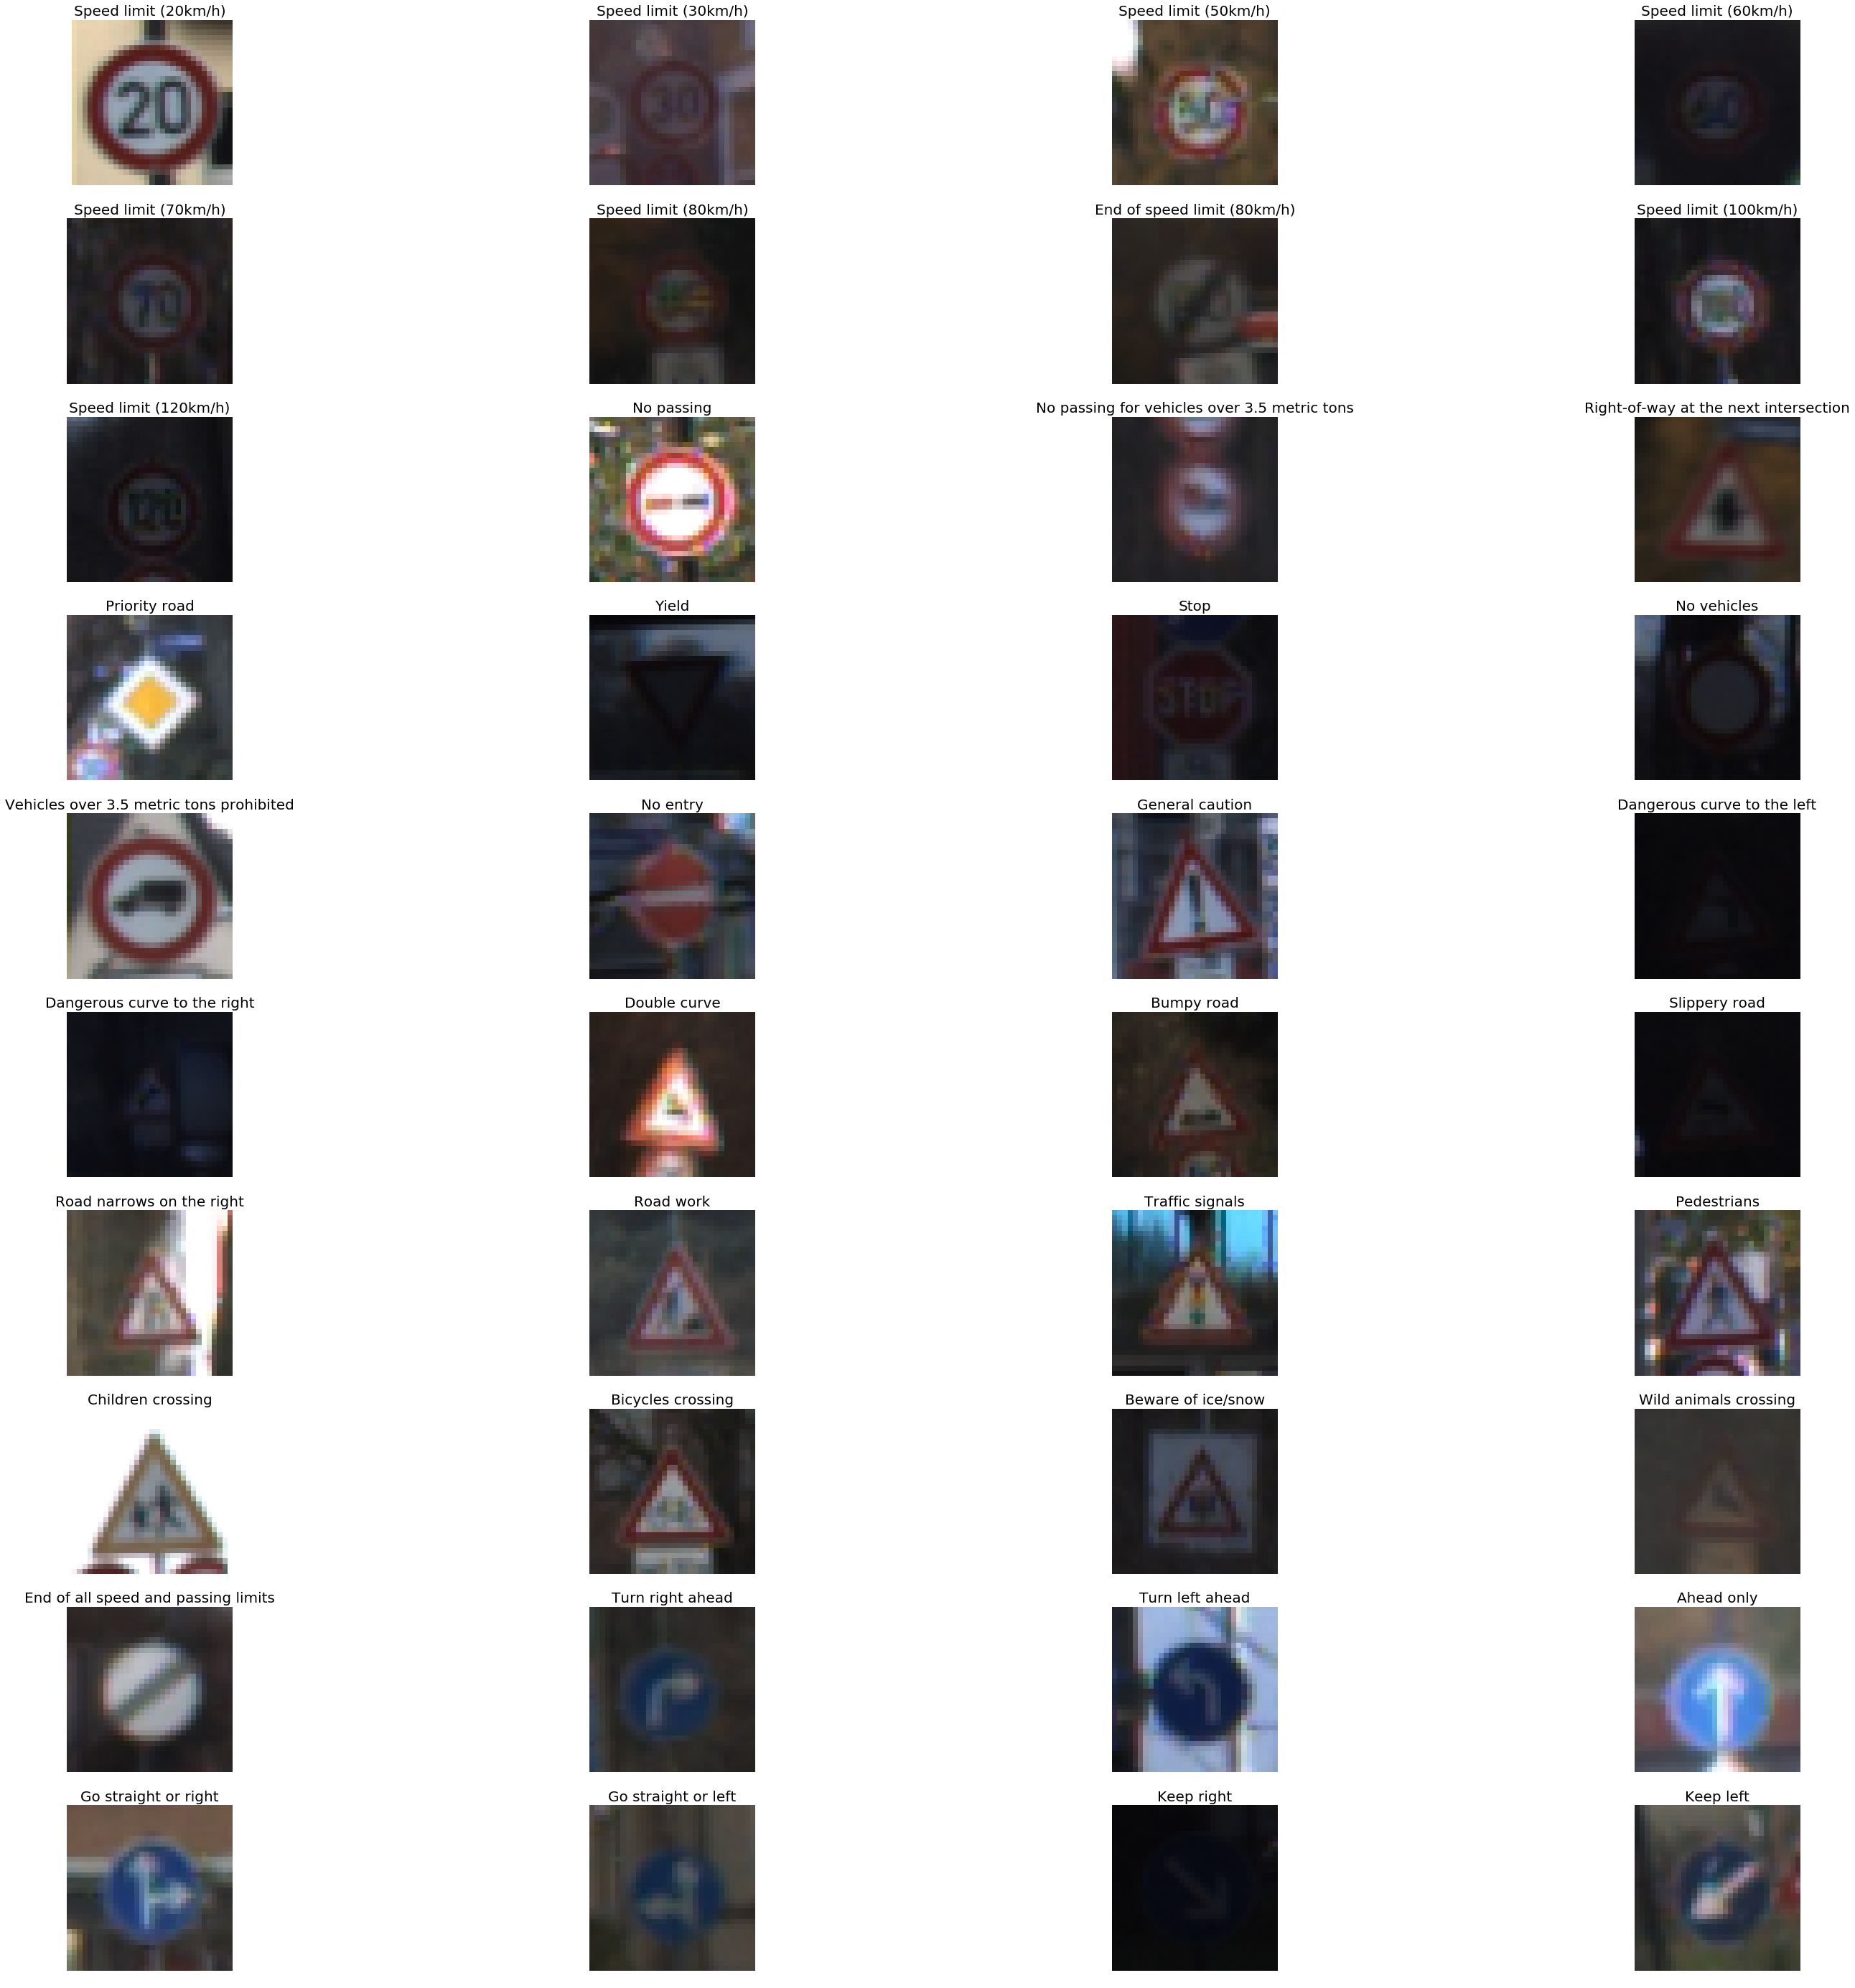

In [6]:
# Data exploration visualization
# This gives better understanding of the data

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
# Visualizations will be shown in the notebook.
%matplotlib inline

#This functions selects one image per class to plot
def get_images_to_plot(images, labels):
    selected_image = []
    idx = []
    for i in range(n_classes):
        selected = np.where(labels == i)[0][0]
        selected_image.append(images[selected])
        idx.append(selected)
    return selected_image,idx
 
# function to plot the images in a grid    
def plot_images(selected_image,y_val,row=5,col=10,idx = None):     
    count =0;
    f, axarr = plt.subplots(row, col,figsize=(50, 50))
   
    for i in range(row): 
         for j in range(col):
                if(count < len(selected_image)):
                    axarr[i,j].imshow(selected_image[count])
                    if(idx != None):
                        axarr[i,j].set_title(traffic_labels_dict[y_val[idx[count]]], fontsize=20)
                axarr[i,j].axis('off')
                count = count + 1
           
            

selected_image,idx = get_images_to_plot(X_train,y_train)
plot_images(selected_image,row=10,col=4,idx=idx,y_val=y_train)

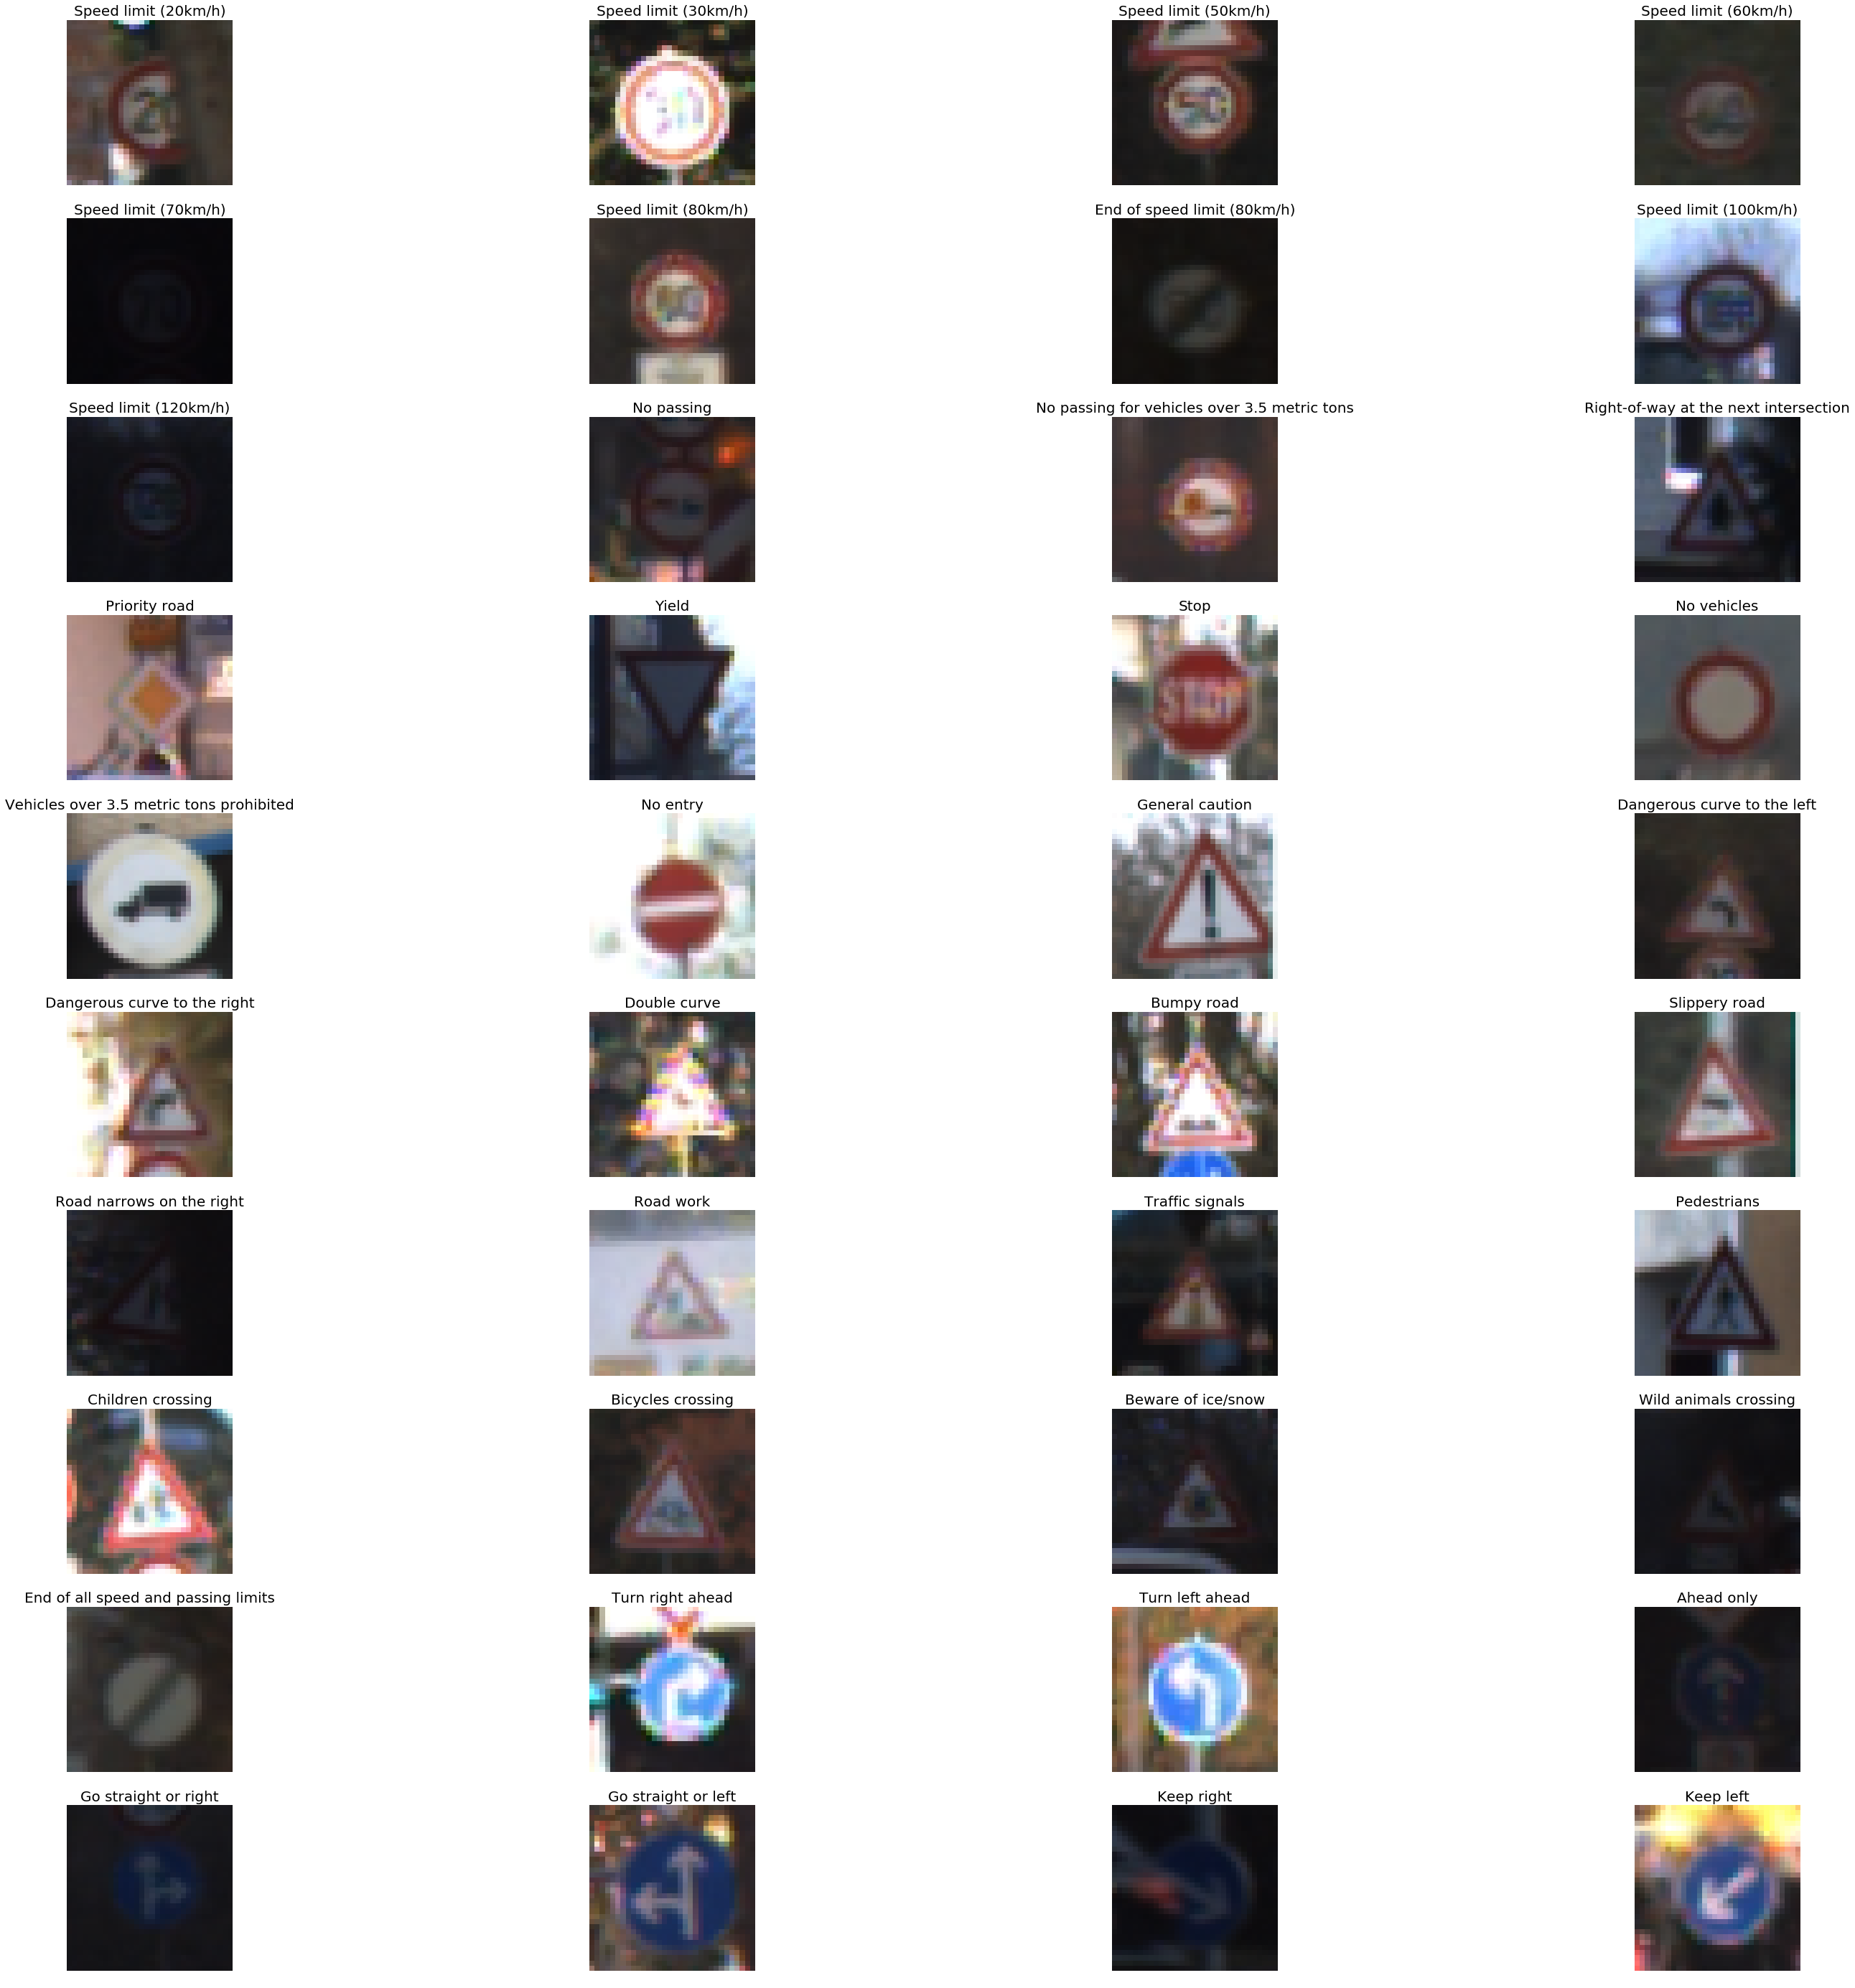

In [7]:
selected_image,idx = get_images_to_plot(X_valid,y_valid)
plot_images(selected_image,row=10,col=4,idx=idx,y_val=y_valid)

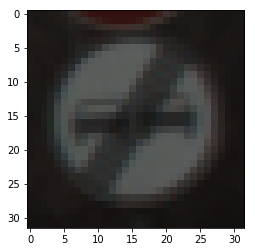

In [8]:
plt.imshow(X_train[28])

## Dealing with unbalanced training data

In [9]:
#Count the number of data associated with each label. We can the data is not evenly distributed across the label
print(np.bincount(y_train))

[ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920  690
  540  360  990 1080  180  300  270  330  450  240 1350  540  210  480  240
  390  690  210  599  360 1080  330  180 1860  270  300  210  210]


We can clearly see the dataset is not balanced. For example, there are 210 images with label 0 and 2220 images with label 1. This will cause a convolutional neural network to favor the more common label. We can solve this by creating extra images in the under-represented labels, a task we'll accomplish by translating some of the existing images by a random amount vertically and horizontally.

In [10]:
# Randomly translates the images (shifts the image)
# Generates additional data with translated image
# Image is input image and trans_range is range of translation
def random_trans(image, trans_range):
    rows,cols,_ = image.shape;
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    tr_y = trans_range * np.random.uniform() - trans_range / 2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image_tr = cv2.warpAffine(image, Trans_M, (cols, rows))
    return image_tr


# Code for balancing dataset
def get_additional(count, label, X_train, y_train):
    selected = np.where(y_train == label)[0]
    counter = 0;
    m = 0;
    # select the first element in selected labels
    X_mqp = X_train[selected[0]]
    X_mqp = X_mqp[np.newaxis, ...]
    while m < (len(selected)):
        aa =  random_trans(X_train[selected[m]],20)
        # ignore the first element, since it already selected
        X_mqp = np.vstack([X_mqp, aa[np.newaxis, ...]])
        if (counter >= count):
            break
        if (m == (len(selected) - 1)):
            m = 0
        counter = counter + 1
        m = m + 1
    Y_mqp = np.full((len(X_mqp)), label, dtype='uint8')

    return X_mqp, Y_mqp

def balance_dataset(X_train_extra, Y_train_extra):
    hist = np.bincount(y_train)
    max_count = np.max(hist)
    for i in range(len(hist)):
        X_mqp, Y_mqp = get_additional(max_count - hist[i], i, X_train, y_train)
        X_train_extra = np.vstack([X_train_extra, X_mqp])
        Y_train_extra = np.append(Y_train_extra, Y_mqp)
        
    return X_train_extra,Y_train_extra

X_train_extra,y_train_extra = balance_dataset(X_train,y_train)
print(y_train_extra.shape)
print(X_train_extra.shape)

(86516,)
(86516, 32, 32, 3)


In [11]:
print(np.bincount(y_train_extra))
#We can see now the dataset is balanced. The labels are equally distributed


[2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012
 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012
 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 2012]


In [12]:
#making sure the images are plotted correctly
#reshape = np.transpose(:,1,2,0)

(86516, 3, 32, 32)


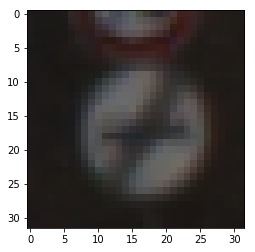

In [13]:
#change the image dimensioning from 32 X 32 X 3 to 3 X 32 X 32 for train

X_train_reshape = np.transpose(X_train_extra, (0, 3, 1, 2))
plt.imshow(X_train_reshape[0].transpose((1,2,0)))
print(X_train_reshape.shape)

(4410, 3, 32, 32)


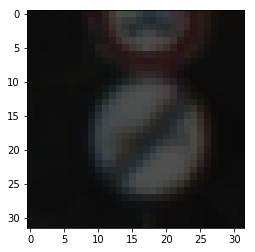

In [14]:
#change the image dimensioning from 32 X 32 X 3 to 3 X 32 X 32 for validation
X_valid_reshape = np.transpose(X_valid, (0, 3, 1, 2))
plt.imshow(X_valid_reshape[1].transpose((1,2,0)))
print(X_valid_reshape.shape)

In [15]:
data = mx.symbol.Variable('data')
conv1 = mx.sym.Convolution(data=data, pad=(1,1), kernel=(3,3), num_filter=24, name="conv1")
relu1 = mx.sym.Activation(data=conv1, act_type="relu", name= "relu1")
pool1 = mx.sym.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool1")
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(3,3), num_filter=48, name="conv2", pad=(1,1))
relu2 = mx.sym.Activation(data=conv2, act_type="relu", name="relu2")
pool2 = mx.sym.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool2")

conv3 = mx.sym.Convolution(data=pool2, kernel=(5,5), num_filter=64, name="conv3")
relu3 = mx.sym.Activation(data=conv3, act_type="relu", name="relu3")
pool3 = mx.sym.Pooling(data=relu3, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool3")
# first fullc layer
flatten = mx.sym.Flatten(data=pool3)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500, name="fc1")
relu3 = mx.sym.Activation(data=fc1, act_type="relu" , name="relu3")
# second fullc
fc2 = mx.sym.FullyConnected(data=relu3, num_hidden=43,name="final_fc")
# softmax loss
mynet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')


In [16]:
mynet.list_arguments()

['data',
 'conv1_weight',
 'conv1_bias',
 'conv2_weight',
 'conv2_bias',
 'conv3_weight',
 'conv3_bias',
 'fc1_weight',
 'fc1_bias',
 'final_fc_weight',
 'final_fc_bias',
 'softmax_label']

In [17]:
batch_size = 64
X_train_set_as_float = X_train_reshape.astype('float32')
X_train_set_norm = X_train_set_as_float[:] / 255.0;

X_validation_set_as_float = X_valid_reshape.astype('float32')
X_validation_set_norm = X_validation_set_as_float[:] / 255.0 ;


train_iter =mx.io.NDArrayIter(X_train_set_as_float, y_train_extra, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_validation_set_as_float, y_valid, batch_size,shuffle=True)


print("train set : ", X_train_set_norm.shape)
print("validation set : ", X_validation_set_norm.shape)


print("y train set : ", y_train_extra.shape)
print("y validation set :", y_valid.shape)


train set :  (86516, 3, 32, 32)
validation set :  (4410, 3, 32, 32)
y train set :  (86516,)
y validation set : (4410,)


In [18]:
#Create Adam optimiser
adam = mx.optimizer.create('adam')

#Checkpointing (saving the model). Make sure there is folder named models exist
model_prefix = 'models/chkpt'
checkpoint = mx.callback.do_checkpoint(model_prefix)
                                       
#Loading the module API. Previously mxnet used feedforward (deprecated)                                       
model =  mx.mod.Module(
    context = mx.gpu(0),     # use GPU 0 for training; if you don't have a gpu use mx.cpu()
    symbol = mynet,
    data_names=['data']
   )
                                       
#actually fit the model for 10 epochs. Can take 5 minutes                                      
model.fit(
    train_iter,
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 64),
    num_epoch = 10, 
    eval_metric='acc',
    optimizer = adam,
    epoch_end_callback=checkpoint
)

/home/sookinoby/miniconda2/envs/mxnet/lib/python3.5/site-packages/mxnet/module/base_module.py:451: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  optimizer_params=optimizer_params)
INFO:root:Epoch[0] Batch [64]	Speed: 8612.61 samples/sec	Train-accuracy=0.033413
INFO:root:Epoch[0] Batch [128]	Speed: 10153.67 samples/sec	Train-accuracy=0.044189
INFO:root:Epoch[0] Batch [192]	Speed: 10740.10 samples/sec	Train-accuracy=0.050781
INFO:root:Epoch[0] Batch [256]	Speed: 10631.26 samples/sec	Train-accuracy=0.062500
INFO:root:Epoch[0] Batch [320]	Speed: 10724.22 samples/sec	Train-accuracy=0.070068
INFO:root:Epoch[0] Batch [384]	Speed: 10682.56 samples/sec	Train-accuracy=0.103760
INFO:root:Epoch[0] Batch [448]	Speed: 10660.71 samples/sec	Train-accuracy=0.176514
INFO:root:Epoch[0] Batch [512]	Speed: 10457.84 samples/sec	Train-accuracy=0.219727
INFO:root:Epoch[0] Batch [576]	Speed: 10670.

In [19]:
acc = mx.metric.Accuracy()
model.score(val_iter,acc)
print(acc)


EvalMetric: {'accuracy': 0.88654891304347827}


In [20]:
# Load the model from the checkpoint , we are loading the 10 epoch
sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, 10)

# Assign the loaded parameters to the module
mod = mx.mod.Module(symbol=sym, context=mx.cpu())
mod.bind(for_training=False, data_shapes=[('data', (1,3,32,32))])
mod.set_params(arg_params, aux_params)

/home/sookinoby/miniconda2/envs/mxnet/lib/python3.5/site-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


<span style="color:red";>Could you find a CC-licensed image to use as test/demo data? Thanks!</span>

class=Keep right
class=Go straight or right
class=Turn left ahead
class=Ahead only
class=Roundabout mandatory


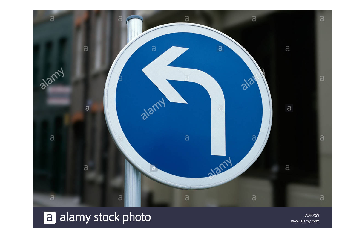

In [35]:
#Prediction for random traffic sign from internet
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

#load the image , resizes it to 32*32 and converts it to 1*3*32*32 
def get_image(url, show=False):
    # download and show the image
    img =cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (32, 32))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) #swaps axis to make it 3*32*32
    #plt.imshow(img.transpose(1,2,0))
    #plt.axis('off')
    img = img[np.newaxis, :] # Add a extra axis to the image so it becomes 1*3*32*32
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    prob = np.argsort(prob)[::-1]
    for i in prob[0:5]:
        print('class=%s' %(traffic_labels_dict[i]))

predict('traffic-data/turn-left-ahead2.jpg',)


In [22]:
#data_iter = mx.io.NDArrayIter(data=data, label=label, batch_size=30)